<img   src="../figuras/logos/Logo TalentQ Azul.png" align=right  width="12%"/>
<br>

<table width="100%">
<td style="font-size:40px;font-style:italic;text-align:left;background-color:rgba(0, 220, 170,0.7)">
El arte de medir II
</td></table>



$ \renewcommand{\bra}[1]{\langle #1|} $
$ \renewcommand{\ket}[1]{|#1\rangle} $
$ \renewcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \renewcommand{\i}{{\color{blue} i}} $ 
$ \renewcommand{\Hil}{{\mathcal H}} $
$ \renewcommand{\boldn}{{\bf n}} $
$ \renewcommand{\tr}{{\rm tr}}$



In [6]:
import sys
sys.path.append('../')
import macro_tQ as tQ

import numpy as np
import scipy.linalg as la
from IPython.display import display,Markdown,Latex
import matplotlib.pyplot as plt
from qiskit.visualization import array_to_latex

# Medidas de estados multicúbit

Un aparato de medida en la base  asociada al operador hermítico $\sigma_z^{\otimes n} = Z\otimes \ldots \otimes Z$ hace colapsar el estado  que mide a un elemento $\ket{x}$ de la *base computacional*, que identificamos mediante una cadena de bits $a_{n-1}...a_0$ con $a_i=0,1$,  donde $x= a_{n-1}2^{n-1}+...+2^0 a_0$.


<br>

<figure><center>
<a id='fig_ref'></a>
<img src="images/Multimeter_zbasis.png" align=center width='50%'/>
<center></center>
</center></figure>


## Circuitos con múltiples cúbits y medidas en Qiskit
<br>



Inicialicemos un estado de 3 cúbits 
$$
\ket{\psi} = \sum_{i,j,k = 0,1} c_{ijk} \ket{ijk} = \sum_a c_a \ket{a}
$$

In [7]:
from numpy import linalg as la
from qiskit.quantum_info import Statevector

'''definimos un estado de entrada en H^3$'''
psi =[1.,-2, -2,1,1,0,2,-1]
psi/=la.norm(psi)
#psi = tQ.random_ket(8).reshape(8)


Statevector(psi).draw('Latex')

<IPython.core.display.Latex object>

Las medida es esencialmente un mapa entre n-cúbits cuánticos y n-bits clásicos.

$$
\ket{i_{n-1} i_{n-2}\, ... \, i_0} \in \Hil^{\otimes n}  ~~~ \to ~~~ i_{n-1}i_{n-2}...i_0\in \{0,1\}^n
$$

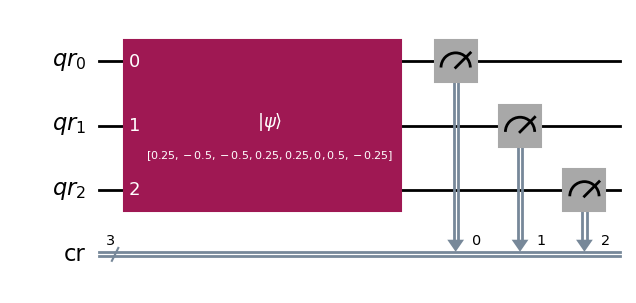

In [8]:
from qiskit import ClassicalRegister, QuantumRegister,QuantumCircuit

qr = QuantumRegister(3,name='qr')
cr = ClassicalRegister(3,name='cr')

qc = QuantumCircuit(qr,cr)
qc.initialize(psi,qr)

qc.measure(qr,cr)
#qc.measure(qr,reversed(list(cr)))  # esta opcion invierte la asignación de bits clasicos a cúbits
#qc.measure([qr[0],qr[1]],[cr[1],cr[2]])

qc.draw(output='mpl')

La manera de tener acceso a las amplitudes (tomografía del estado) es midiendo repetidas veces para reconstruir la función de probabilidad

Cuentas= {'100': 6234, '110': 25004, '001': 25259, '000': 6313, '010': 24616, '111': 6318, '011': 6256}


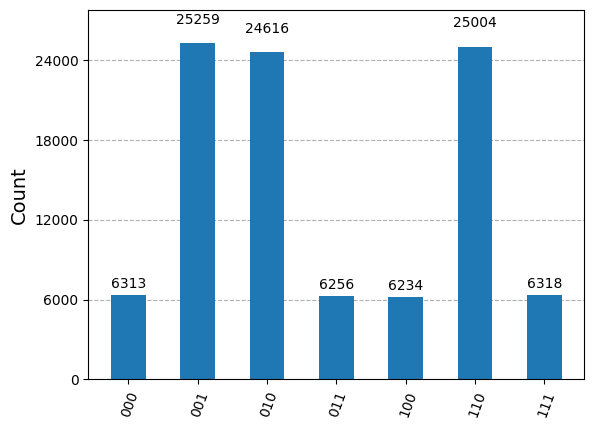

In [9]:
from qiskit_aer import Aer, AerSimulator
#simulator = Aer.get_backend('aer_simulator')
simulator = AerSimulator()

'numero todal de medidas'
nshots = 100000

'ejecutamos el circuito'
counts=simulator.run(qc,shots=nshots).result().get_counts() 
print('Cuentas=',counts) #diccionario de cuentas


from qiskit.visualization import plot_histogram
plot_histogram(counts) # Mostramos un histograma de resultados

Ahora podemos generar diccionarios con las probabilidades y la amplitudes de los distintos resultados, para obtener la tomografía del estado 

In [5]:
def get_probs(cuentas): # frecuencias_dict es un diccionario con la estadística de resultados
    
    prob_dict=cuentas.copy() # vamos a modificar el diccionario "cuentas" con las probabilidades 
    keys = list(cuentas.keys())
    values = list(cuentas.values())
    
    N=sum(values)
    probabilidades = [v/N for v in values] # lista de frecuencias relativas
 
    for i in range(len(keys)):
        prob_dict[keys[i]]= probabilidades[i]
    
    return  prob_dict

probs = get_probs(counts)

print("Probabilidades =",probs )



Probabilidades = {'110': 0.25025, '100': 0.06182, '001': 0.25177, '111': 0.06238, '011': 0.06154, '000': 0.06178, '010': 0.25046}


# Medidas en bases generales

Vamos a suponer que queremos medir en una base ortonormal arbitraria $\{\ket{ x}'\}$, $x=0,...,2^n-1$. 

$\Rightarrow~ $ buscamos un circuito que, a la llegada de un vector  concreto de la base $\ket{x}'=\ket{i_{n-1}...i_0}'$, devuelva exactamente *la  colección* de bits:  $~i_{n-1}...i_0$.

Vamos a suponer que conocemos el operador unitario que relaciona esta base con la  base computacional  

$$\ket{ x}'= U\ket{x}~~~~~~\Longrightarrow ~~~~~~   U^\dagger\ket{x}' = \ket{ x}  \, .$$



Entonces es evidente que sólo tenemos que añadir el operador $U^\dagger$ antes de usar el medidor estándar


<br>

<center>
<figure>
<a id='fig_ref'></a>
<img src="images/Multimeter_basis.png" align=center width='50%'/>
<center></center>
</figure>
</center>


## Medidas  de Pauli

En caso más frecuente consiste en medir diferentes cúbits en diferentes bases de Pauli, $X$, $Y$ ó $Z$.

En este caso, $U= R_1\otimes \ldots \otimes R_n$ es un producto de *rotaciones locales*, $Z\to X$ ó $Z\to Y$ 

 Por ejemplo el siguiente circuito mide en la base $YXZ \sim Y_2X_1Z_0$

<br>

<center>
<figure>
<a id='fig_ref'></a>
<img src="images/XYZ_multimeter.png" align=center width='25%'/>
<center></center>
</figure>
</center>
<br>

Definamos una función que añade aparatos de medida en bases $X$, $Y$ ó $Z$ a partir de una *cadena* como 'xxy' etc 


In [10]:
def add_multimeasure_XYZ(qc,paulistring):

    assert(qc.num_qubits==len(paulistring)) #check whether width of circuit coincides with length of Pauli string
    
    # reverse the order of the string to place the rightmost gate at the top
    for i,basis in enumerate(reversed(paulistring)):
        if  basis == 'X':
            qc.h(i)    
            qc.measure(i, i)
        elif basis == 'Z':
            qc.measure(i, i)
            pass    
        elif basis == 'Y':
            qc.sdg(i)
            qc.h(i)
            qc.measure(i, i)

    return qc 

Veamos un ejemplo

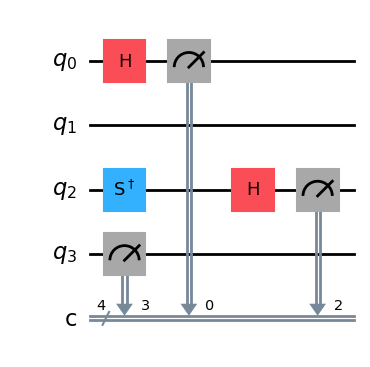

In [11]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(4,4)
add_multimeasure_XYZ(qc,'ZYIX')  # probar a cambiar el aparato de medida
qc.draw('mpl')

## Medida de Bell

El circuito 

<figure>
<a id='fig_ref'></a>
<img src="images/Bell_basis.png" align=center width='200px'/>
<center></center>
</figure>

<br>

 genera la <i>base de Bell</i> $\ket{B_{xy}} = \ket{xy}_B $ a partir de la <i>base computacional</i> $\{\ket{xy}\}$ 
 <br>
<br>

\begin{array}{rcl}
\ket{00}_B &=& \frac{1}{\sqrt{2}} \big( \ket{00} + \ket{11} \big) \\
\ket{01}_B &=& \frac{1}{\sqrt{2}} \big( \ket{00} - \ket{11} \big) \\
\ket{10}_B &=& \frac{1}{\sqrt{2}} \big( \ket{01} + \ket{10} \big) \\
\ket{11}_B &=& \frac{1}{\sqrt{2}} \big( \ket{01} - \ket{10} \big) \\
\end{array}




El circuito que efectúa una **medida de Bell**  

$$
\ket{xy}_B \to xy
$$
utiliza el *desentrelazador* 

$$U^\dagger = ( \hbox{CNOT}\cdot H)^\dagger = H\cdot \hbox{CNOT}$$ 

antes del medidor 

<br>

<center>
<figure>
<a id='fig_ref'></a>
<img src="images/Bell_meter.png" align=center width='40%'/>
<center></center>
</figure>
</center>



Creemos el circuito

In [12]:
def add_Bell_measurement(qc,qubits=[0,1]):
    qc.cx(qubits[0],qubits[1])
    qc.h(0)
    qc.barrier()
    qc.measure([0,1],[0,1])

Ahora verificamos

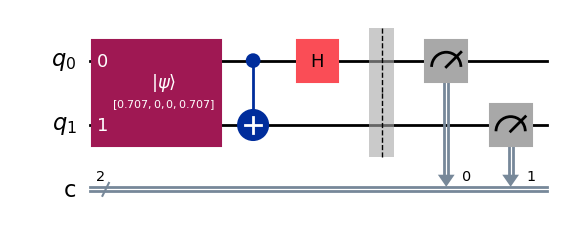

{'00': 1}

In [13]:
from qiskit import QuantumCircuit

# creamos el circuito
qc = QuantumCircuit(2,2)

# definimos la base de Bell
B00 = np.array([1,0,0,1]/np.sqrt(2))
B01 = np.array([1,0,0,-1]/np.sqrt(2))
B10 = np.array([0,1,1,0]/np.sqrt(2))
B11 = np.array([0,1,-1,0]/np.sqrt(2))

# inicializamos el estado de entrada en cualquiera de los estados anteriores
qc.initialize(B00,[0,1])

# añadimos el medidor en la base de Bell
add_Bell_measurement(qc)
display(qc.draw('mpl'))

AerSimulator().run(qc,shots=1).result().get_counts()

# Valores esperados de observables multi-cúbit

El *problema* esencial para medir un valor esperado $\bra{\psi} A \ket{\psi}$ es que, en general,  $A$ **no es un operador unitario**. Por tanto no se puede incluir como parte de un circuito

Si pudiésemos expresar  como una combinación de operadores unitarios, $A = \sum_i c_i U_i$, entonces sí podríamos calcular cadar valor esperado $\langle U_i\rangle$ mediante un circuito y, finalmente, componer el resultado $\langle A\rangle = \sum_i c_i \langle U_i\rangle$

Una base  la constituyen las *cadenas de Pauli*,  $U = \sigma_{i_1}\otimes \ldots \otimes \sigma_{i_n}$ que son, a la vez, hermíticas y unitarias, y permiten expandir cualquier operador hermítico

\begin{equation}
A = \sum_{i_1,...,i_n=0}^3 a_{i_1\ldots i_n} \, \sigma_{i_1}\otimes \ldots \otimes \sigma_{i_n}
\end{equation}

donde $\sigma_i = (I,X,Y,Z)$


Por ejemplo, con $n=3$ 
$$
\sigma_2\otimes \sigma_0 \otimes \sigma_3 =  Y\otimes I\otimes Z 
$$

En Numpy el producto de Kronecker se invoca con la función *kron*

In [14]:
' Matrices de Pauli'
s0 = np.matrix([[1,0],[0,1]]) # matriz identidad
s1 = np.matrix([[0,1],[1,0]])
s2 = np.matrix([[0,-1j],[1j,0]])
s3 = np.matrix([[1,0],[0,-1]])

Pauli_basis = [s0,s1,s2,s3]

' Cadena de Pauli YIZ = s2s0s3' 
Pauli_string_203 = np.kron(s2,np.kron(s0,s3))
array_to_latex(Pauli_string_203)

<IPython.core.display.Latex object>

las componentes se pueden obtener calculando las trazas

$$
a_{i_1\ldots i_n} =\frac{1}{2^n} \tr \, (A \,  \sigma_{i_1}\otimes \ldots  \otimes\sigma_{i_n})
$$


<div class='alert alert-block alert-success'>
    <b>Ejercicio </b> 
<br>
demuestra este resultado. Muestra que estos coeficientes son todos reales si y sólo si $A$ es hermítica.    
</div>

In [15]:
'Matriz arbitraria'
A = np.random.rand(8,8) + 1j* np.random.rand(8,8)


'Componente'
a_203 = np.trace(np.dot(A,Pauli_string_203))/2**3

print('a_{203} = ', a_203)

a_{203} =  (0.05470278053416054-0.049336744239632344j)



Por tanto sólo tenemos que averiguar los valores esperados de cadenas de Pauli
<br>

$$
\langle \sigma_{i_1}\otimes \ldots   \otimes\sigma_{i_n}\rangle_\psi = \bra{\psi} \sigma_{i_1}\otimes \ldots   \otimes\sigma_{i_n}\ket{\psi}
$$

para poder componer el resultado final 
$$
\langle A \rangle_{\psi} =  \sum_{i_1,...,i_n=0}^3 a_{i_1\ldots i_n} \langle \sigma_{i_1}\otimes \ldots   \otimes\sigma_{i_n}\rangle_\psi
$$

## Valores esperados de cadenas de Pauli

**Ejemplo**: Veamos cómo calcular el valor esperado del operador
<br>
<br>
$$
\langle Z\otimes Z\otimes Z\rangle_\Psi  = \bra{\Psi}   Z\otimes Z\otimes Z \ket{\Psi}
$$

en el siguiente estado

$$
\ket{\psi} = \frac{i}{4}\ket{000}-\frac{i}{2}\ket{001}-\frac{1}{2}\ket{010}+\frac{1}{4}\ket{011}+
\frac{i}{4}\ket{100} + \frac{1}{2}\ket{110} - \frac{1}{4}\ket{111}
$$


Primero lo inicializamos

In [16]:
' estado '
psi =np.array([1j,-2*1J, -2,1,1J,0,2,-1])
psi/=tQ.norm(psi)

#e_init = tq_random_ket(8).reshape(8)

from qiskit.quantum_info import Statevector
Statevector(psi).draw('latex')

<IPython.core.display.Latex object>

Dado que $Z\ket{a} = (-1)^a\ket{a}$ donde $a=0,1$, entonces tendremos que, sobre un estado $\ket{i_2 i_1 i_0}$ de la base computacional
<br>
<br>

$$
Z\otimes Z\otimes Z \ket{i_2 i_1 i_0} = Z\ket{i_2}\otimes Z\ket{i_1}\otimes Z\ket{i_0} = (-1)^{i_2+i_1+i_0}\ket{i_2 i_1 i_0}
$$

<br>

entonces el valor esperado  de este operador es
<br>
<br>

\begin{eqnarray}
\langle Z\otimes Z\otimes Z\rangle_\Psi &=&
\bra{\Psi} Z\otimes Z\otimes Z \ket{\Psi} \\ 
&=& \sum_{i_2,i_1,i_0=0,1}\bra{\Psi} Z\otimes Z\otimes Z \ket{i_2 i_1 i_0}\braket{i_2 i_1 i_0}{\Psi}  \rule{0mm}{10mm}  \\
&=& \sum_{i_2,i_1,i_0=0,1}(-1)^{i_2 + i_1 + i_0}\big|\bra{i_2 i_1 i_0}\Psi\rangle\big|^2 \\ \rule{0mm}{8mm}
&=& \sum_{i_2,i_1,i_0=0,1} (-1)^{i_2 + i_1 + i_0} p(i_2,i_1,i_0) \nonumber\\ 
\end{eqnarray}

El circuito que calcula las probabilidades necesarias es el siguiente

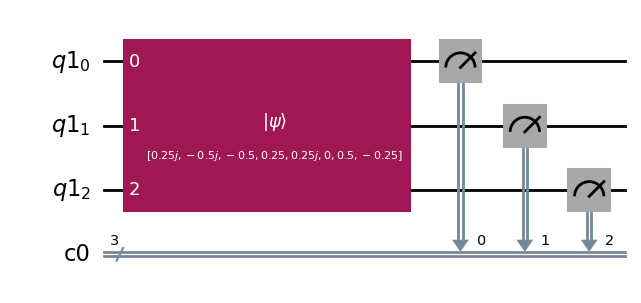

In [17]:
from qiskit import ClassicalRegister, QuantumRegister,QuantumCircuit

qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr,cr)

from qiskit.circuit.library import Initialize

qc.initialize(psi, qr)
qc.measure(qr,cr)
qc.draw(output='mpl')

Ejecutamos el circuito un número de veces y obtenemos el diccionario de cuentas

counts= {'100': 620, '110': 2556, '001': 2504, '011': 617, '111': 576, '010': 2527, '000': 600}


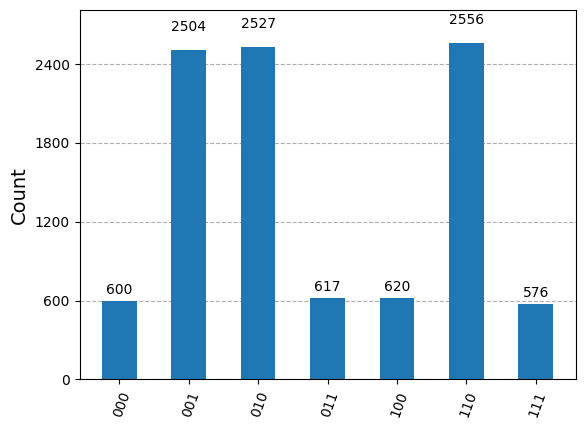

In [18]:
from qiskit_aer import AerSimulator
nshots = 10000


counts = AerSimulator().run(qc,shots=nshots).result().get_counts()
print("counts=", counts)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

Finamente $\langle ZZZ\rangle $ es el valor medio  de una distribución de probabilidad de la forma $\{\lambda(x),p(x)\},$ con $x=(i_2 i_1 i_0)$ y

$$
\lambda(x) = (-1)^{i_{2}+i_1+i_0}~~~~~~,~~~~~~ p(x)= \frac{n(x)}{\sum_x n(x)} = \frac{\hbox{counts}(x)}{\hbox{shots}}
$$

La media será el valor esperado que buscamos

$$
 \langle ZZZ\rangle = \bar \lambda = \sum_x \lambda(x) p(x) = \sum_{x}(-1)^{i_{2}+i_1+i_0}\frac{\hbox{counts}(x)}{\hbox{shots}}
$$

In [19]:
mean = 0.
for bitstring,count  in counts.items():
    mean += (-1)**(sum([int(bit) for bit in bitstring])) * count/nshots 

print('<ZZZ> =', np.round(mean,5) )

<ZZZ> = -0.2454


También podemos obtener la varianza
$$
\sigma^2 = \sum_{x}\left((-1)^{i_{2}+i_1+i_0}-\bar\lambda \right)^2 p(x)
$$

In [16]:
variance=0
for bitstring,count  in counts.items():
    variance += ((-1)**(sum([int(bit) for bit in bitstring]))-mean)**2 * count/nshots 
    
print('sigma = ', np.round(np.sqrt(variance),4) )

sigma =  0.9664


Comprobar con las expresión analíticas

$$\langle ZZZ\rangle = \bra{\psi} ZZZ\ket{\psi} $$

y 

$$
\sigma = \sqrt{\bra{\psi}ZZZ^2\ket{\psi} - \bra{\psi}ZZZ\ket{\psi}^2}
$$

In [17]:
Z = np.array([[1,0],[0,-1]])
ZZZ = np.kron(Z,np.kron(Z,Z))


vev_ZZZ = np.dot(psi.conj().T,np.dot(ZZZ,psi)).real

print("<ZZZ>=",vev_ZZZ)

<ZZZ>= -0.25


Igualmente podemos ver cómo medir el valor esperado

$$
\langle Z\otimes X\otimes Y\rangle_\Psi  = \bra{\Psi}   Z\otimes X\otimes Y \ket{\Psi}
$$

en el mismo estado



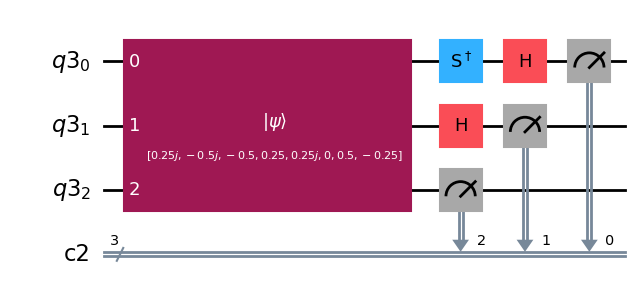

In [25]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

qc2 = QuantumCircuit(qr,cr)


qc2.initialize(psi, qr)
add_multimeasure_XYZ(qc2,'ZXY')
qc2.draw(output='mpl')

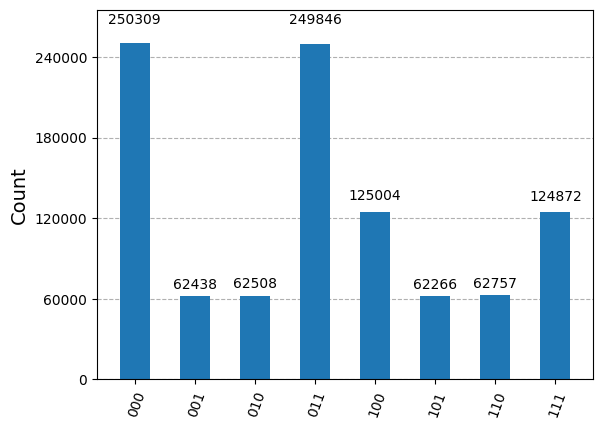

In [19]:
nshots = 1000000

counts2 = AerSimulator().run(qc2,shots=nshots).result().get_counts()
plot_histogram(counts2)

In [20]:
mean = 0
for bitstring,count  in counts2.items():
    mean += (-1)**(sum([int(bit) for bit in bitstring])) * count/nshots 

    
print('<ZXY> =', np.round(mean,5) )

<ZXY> = 0.25036


<div class='alert alert-block alert-success'>
    <b>Ejercicio </b> 
<br>
escribe una función $expval\_pauli(P,u)$ que reciba como dato, un estado $\ket{u}\in \Hil^{\otimes n}$ y una cadena de Pauli $P = IXYZZ...$  y  devuelva el valor esperado $\bra{u}P\ket{u}$.
    
</div>

<div class="alert alert-block alert-success">
 <b>Ejercicio</b>  
    
considera el hamiltoniano $H=\lambda (X X+Y Y+Z Z)$ siendo $\lambda =1.47\cdot 10^{-6}eV$. 
 Calcular el valor esperado de la energía $E = \langle H\rangle_\Psi$  en los cuatro estados de Bell
$\ket{\Psi} = \ket{B_{ij}}$. 
<div>


<div class="alert alert-block alert-success">
 <b>Ejercicio</b>  
    
escribe una función $expect\_value(A,\psi)$ que reciba como argumento un estado $\ket{\psi}$ y un observable $A$, definidos  sobre $\Hil^{\otimes n}$ y devuelva el valor esperado $\bra{\psi}A\ket{\psi}$. Tendrás que generar todas las cadenas de Pauli de longitud $n$. 
<div>


## Medida de Hadamard

Al final, el valor esperado de un operador es un simple número que se obtiene a partir de una distribución aleatoria de valores. 

¿No podríamos diseñar una variable aleatoria cuyo valor medio coincida con ese resultado? 

La medida de Hadamard hace precisamente esto **aprovechando el entrelazamiento**



Consideremos el siguiente circuito

<figure><center>
<a id='fig_ref'></a>
<img src="images/Hadamard_measure.png" align=center width='40%'/>
<center></center>
</center></figure>


El aparato de medida sólo registra valores $\{0,1\}$ como resultado de las medidas proyectivas sobre $\ket{\pm}$

Supongamos que medimos con el aparato $x$. El promedio 

$$
\frac{n_{0}}{N} - \frac{n_{1}}{N} =  + p(0)-p(1) =  \langle X\rangle_{ancilla}
$$

es el valor esperado de $X$ en la ancilla. 


Análogamente, será $\langle Y\rangle_{ancilla}$  si usamos el aparato $y$. 

Vamos a demostrar el siguiente resultado que relaciona este número con el valor esperado de $U$ en el estado $\ket{\psi}$


<div class="alert alert-block alert-info",text-align:center>
<p style="text-align: left ;color: navy;">  

<b>Teorema:</b>
<br>

$$
\langle X\rangle_{ancilla} = {\rm Re} \langle U\rangle_{\psi} ~~~,~~~ \langle Y\rangle_{ancilla} = {\rm Im} \langle U\rangle_{\psi}\, 
$$
<br>
</div>



**Demostración**: para el caso $x$, el circuito anterior será
<br>
<br>

<figure><center>
<a id='fig_ref'></a>
<img src="images/Hadamard_measurea.png" align=center width='40%'/>
<center></center>
</center></figure>

<br>


Un cálculo explícito nos da el estado que llega al aparato de medida
<br>

$$
\ket{0}\ket{\psi} ~~\longrightarrow ~~ \ket{\Psi} = \frac{1}{2} \big[\rule{0mm}{3mm} \ket{0}\otimes  (1 + U) 
|\psi\rangle  + \ket{1}\otimes   (1 - U) \ket{\psi} \big] 
$$


Si medimos el cúbit ancilla, obtendremos como resultados, valores  $0$ y $1$ con probabilidades 
<br>
<br>
\begin{align} 
 p(0)  &=  \left\vert \frac{1}{2}  (1 + U) \ket{\psi}  \right\vert^{2} = 
 \frac{1}{4}\bra{\psi}(1 + U^\dagger) (1 + U) \ket{\psi} =\frac{1}{2}(1+\operatorname{Re}\langle \psi|U|\psi\rangle) \nonumber\\ \rule{0mm}{12mm}
 p(1)  &= \left\vert \frac{1}{2}  (1 - U) \ket{\psi}  \right\vert^{2}=
 \frac{1}{4}\bra{\psi}(1 - U^\dagger) (1 - U) \ket{\psi} =
 \frac{1}{2}(1-\operatorname{Re}\langle \psi|U|\psi\rangle) \nonumber
\end{align}
<br>


El número $ p(0) - p(1)$ es el valor esperado de $\langle X\rangle $ en el estado de la ancilla justo  antes de la barrera. Encontramos el siguiente resultado 

$$
\langle{X}\rangle_{ancilla}  =  \hbox{Re}\bra{\psi} U \ket{\psi}
$$

Supongamos ahora que medimos en la base $Y$, es decir, con el circuito siguiente

<br>
<figure><center>
<a id='fig_ref'></a>
<img src="images/Hadamard_measureb.png" align=center width='50%'/>
<center></center>
</center></figure>
<br>


<div class="alert alert-block alert-success">
<b>Ejercicio 1.2.2.3</b>
<br>   
<br>    
verificar que la parte imaginaria viene de medir  $\langle Y\rangle$ en la ancilla

$$
\langle{Y}\rangle_{ancilla}  =  \hbox{Im}\bra{\psi} U \ket{\psi} \, .
$$
<br>
</div>

Vamos a recuperar el valor esperado de $\langle Z\otimes Z\otimes Z\rangle_\psi$ en el estado 

$$
\ket{\psi} = \frac{i}{4}\ket{000}-\frac{i}{2}\ket{001}-\frac{1}{2}\ket{010}+\frac{1}{4}\ket{011}+
\frac{i}{4}\ket{100} + \frac{1}{2}\ket{110} - \frac{1}{4}\ket{111}
$$

usando el método de Hadamard. Generamos el circuito de medida de Hadamard

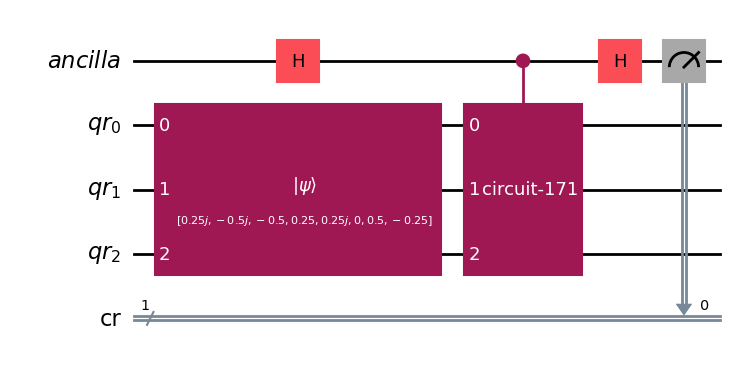

In [21]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister

qr = QuantumRegister(3, name = 'qr')
qra = QuantumRegister(1, name = 'ancilla')
cr = ClassicalRegister(1,"cr")

'creamos el operador como una puerta "gate"  '
qc0 = QuantumCircuit(qr)
qc0.z(qr)
'que admite el método "control" '
CZZZ_gate = qc0.to_gate().control(1,ctrl_state= 1) 

'creamos el circuito con el operador controlado'
qc_Had = QuantumCircuit(qra,qr,cr)
qc_Had.initialize(psi,qr)
qc_Had.h(qra)  
qc_Had.append(CZZZ_gate,qra[:] + qr[:])

'añadimos el aparato de medida en la dirección de X o de Y'
#qc_Had.sdg(qra) #descomentar para Y, comentar para X
qc_Had.h(qra)
qc_Had.measure(qra,cr)

qc_Had.draw('mpl')

Ejecutamos y obtenemos el valor esperado

Al haber añadido un circuito convertido en puerta, tenemos que compilar el circuito antes de ejecutarlo

In [34]:
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile

simulator = AerSimulator()

ac_Had_compiled = transpile(qc_Had,backend = simulator)

counts_Had = simulator.run(ac_Had_compiled,shots=nshots).result().get_counts()


Si quisieramos mandar el circuito a un ordenador cuántico necesitaríamos la clase Sampler

https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Sampler


In [36]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

nshots = 1000000

# Run the sampler
result = sampler.run([qc_Had], shots=nshots).result()[0]
counts_Had = result.data.cr.get_counts()


counts= {'0': 375092, '1': 624908}


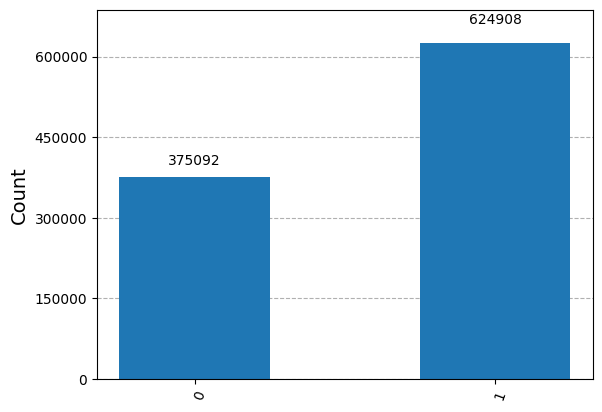

In [37]:
from qiskit.visualization import plot_histogram
print("counts=", counts_Had)
plot_histogram(counts_Had)

In [24]:
mean = 0
for bitstring, count  in counts_Had.items():
    mean += (-1)**(int(bitstring)) * count/nshots

   
print('<X> = Re(<ZZZ>) = <ZZZ> =', np.round(mean,5) )

<X> = Re(<ZZZ>) = <ZZZ> = -0.25156


<div class="alert alert-block alert-success">
    <b>Ejercicio 1.2.2.5</b> 
    
define una función <i>add_Hadamadard_measure</i> que reciba un circuito y una  cadena de Pauli y añada al circuito el medidor de Hadamard asociado.
</div>

### Medida no demoledora

Vamos a ver que el circuito de Hadamard permite hacer medidas que no destruyen el estado. 
Supongamos el operador $U$ es un operador sobre 1 cúbit *a la vez hermítico y unitario*.

Entonces, los autovalores deben ser a la vez fases puras, y reales. 

Ello deja a $\lambda = \pm 1$ como los únicos autovalores posibles para un operador así. 

Los operadores $X,Y,Z$ son ejemplos de este tipo, pero también combinaciones como
$U = \boldn\cdot \boldsymbol{\sigma}$




Denotaremos con $\ket{a}_U$ los autovectores de $U$ con autovalores $(-1)^a$. Es decir $U\ket{0}_U = \ket{0}_U$ y $U\ket{1}_U = -\ket{1}_U$   


En este caso, los factores $(1\pm U)$ que aparecen en la medida de Hadamard son proyectores ortogonales sobre los autoestados de $U$
<br>
<br>
<figure><center>
<a id='fig_ref'></a>
<img src="images/HadamardProjection.png" align=center width='40%'/>
<center></center>
</center></figure>
<br>


Antes de medir el estado será el siguiente

$$
\begin{array}{rcl}
\ket{0}\ket{\psi} ~~\longrightarrow ~~ \ket{\Psi} &=&\displaystyle \frac{1}{2} \big[  \ket{0}\otimes  (1 + U)\ket{\psi}  + \ket{1}\otimes   (1 - U) \ket{\psi} \big] \\ \rule{0mm}{8mm}
&=& \displaystyle \big[  \ket{0}\otimes \frac{1}{2} (1 + U)(\alpha\ket{0}_U + \beta\ket{1}_U)  + \ket{1}\otimes   \frac{1}{2}(1 - U) (\alpha\ket{0}_U + \beta\ket{1}_U) \big] \\  \rule{0mm}{8mm}
&=& \alpha\ket{0}\ket{0}_U +  \beta\ket{1}\ket{1}_U
\end{array}
$$
<br>

Vemos que el circuito de Hadamard entrelaza maximalmente los autoestados de $Z$ y de $U$. Al igual que con los estados de Bell, cada resultado de  medida en la ancilla está correlacionado con un autoestado del operador $U$. 


Si la medida es destructiva sobre la ancilla, el cúbit de trabajo se proyecta sobre uno de sus autoestados y sigue su camino en dicho autoestado.